In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os

# set paths/create objects

cp1 = day-0

cp2 = day-n

In [3]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_170929_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171001_No Obstacles_s.mat'

cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

cca_object = CCAProcessor(cp1, cp2)

this is filipe data i belive
this is filipe data i belive
should be good to align
(8945, 11)
(8945, 5)
(8945, 23)
(8945, 5)


# Getting PCA dimensions

In [4]:
#dimensions is lower of PCAn
nada, nada = cca_object.apply_PCA()
lowest_num_dimensions = cca_object.num_components
print(lowest_num_dimensions)

6


# storing day-n raw (unaligned, unprocessed) data as test sets

In [5]:
#get unprocessed day2 neural data as test set
testing_x = np.squeeze(cp2.data['rates'])
test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions)))
test_y = np.squeeze(np.array(cp2.data['angles']))

test_x_format, test_y_format = format_data(test_x, test_y)

#scaled version
scaler = StandardScaler()
test_x_scale = scaler.fit_transform(test_x)

test_x_format_scale, nada = format_data(test_x_scale, test_y)

In [6]:
#subsampling list, percent of total data
subsample_list = [.005, .01, .02, .05, .1, 1.0]
nummy = test_x_format.shape[0]
newlist = [int(sub * nummy) for sub in subsample_list]

print(f'num_samples:{newlist}')

num_samples:[60, 120, 240, 601, 1202, 12029]


# getting day0 decoder
apply PCA, and then train wiener filter.
also get a day0-scaled-weights-decoder

In [7]:
#get day0 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(lowest_num_dimensions))
print(np.average(nada, 1)[1])

X_tempy =cp1.apply_PCA(lowest_num_dimensions)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(np.average(nada, 1)[1])

0.538
0.538


# getting JUST-PCA decoder
we subsample day-n data, apply PCA, and then train a wiener filter on it to spit out a decoder. Then we try decoder on the day2-test set

In [8]:
pca_decoder = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    pca_decoder.append(temp_h)

# getting CCA scores 

In [9]:
cca_decoder_scores = []
cca_transformers=[]
new_cca_decoder_scores=[]
for i in range(len(subsample_list)):
    sub_x1, sub_y1, sub_x2, sub_y2 = cca_object.subsample(percent = subsample_list[i])
    
    pca_sub_x1, pca_sub_x2 = cca_object.apply_PCA(cp1_x = sub_x1, cp2_x = sub_x2, preset_num_components=lowest_num_dimensions)
    temp_cca_transformer, nada = cca_object.apply_CCA(cp1_x = pca_sub_x1, cp2_x = pca_sub_x2, preset_num_components = lowest_num_dimensions)
    
    cca_transformers.append(temp_cca_transformer)
    nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    
    temp_x_format, nada = format_data(temp_x, test_y)
    predic = test_wiener_filter(temp_x_format, day0_decoder)
    
    pca_sub_x1_format, nada = format_data(pca_sub_x1, sub_y1)
    pca_sub_x2_format, nada = format_data(pca_sub_x2, sub_y2)
    
    #temp_cca_transformer_format, nada = cca_object.apply_CCA(cp1_x = pca_sub_x1_format, cp2_x = pca_sub_x2_format, preset_num_components = lowest_num_dimensions)
    #nada, test_x_cca_space_format = temp_cca_transformer_format.transform(test_x_format, test_x_format)
    #new_temp_x_format = temp_cca_transformer_format.inverse_transform(test_x_cca_space_format)
    #new_predic = test_wiener_filter(new_temp_x_format, day0_decoder)
    
    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))
    #new_cca_decoder_scores.append(vaf(test_y_format[:,1], new_predic[:,1]))
print(cca_decoder_scores)

[-0.96, -0.07, 0.24, 0.36, 0.1, 0.49]


In [10]:
len(cca_transformers)

6

# regression fit

In [11]:
r_scores = []

for i in range(len(subsample_list)):
    #subsample day-n unprocessed data
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    
    #apply PCA to subsampled data
    sub_x_pca = np.squeeze(cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x))
    #transform PCA subsample to day-0 shape
    nada, sub_x_cca_space = cca_transformers[i].transform(sub_x_pca, sub_x_pca)
    temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
    #scale transformed data 
    scaler = StandardScaler()
    temp_x_scale = scaler.fit_transform(temp_x)

    wpost = ridge_fit(b0=day0_decoder_scale, x=temp_x_scale, y=np.squeeze(sub_y), my_alpha=100.0)
    
    
    ###now lets test on full dataset
    nada, test_xx = cca_object.apply_CCA(cp2_x = test_x, transformer = cca_transformers[i])
    test_xx_scale = scaler.transform(test_xx)
    test_xx_scale_format, nada = format_data(test_xx_scale, test_y)
    temp_y = test_wiener_filter(test_xx_scale_format, wpost)
    
    i_love_you = vaf(test_y_format[:,1], temp_y[:,1])
    print(f'please for god sake: {i_love_you}')
    print('\n')
     
    
    r_scores.append(i_love_you)

initial_scoring is : -0.82
new_scoring is: 0.71
please for god sake: 0.33


initial_scoring is : 0.01
new_scoring is: 0.76
please for god sake: 0.43


initial_scoring is : 0.4
new_scoring is: 0.76
please for god sake: 0.32


initial_scoring is : -0.0
new_scoring is: 0.81
please for god sake: 0.45


initial_scoring is : 0.05
new_scoring is: 0.74
please for god sake: 0.67


initial_scoring is : 0.52
new_scoring is: 0.78
please for god sake: 0.78




In [12]:
fixed_decoder_scores=[]
pca_decoder_scores=[]
r_decoder_scores=[]

for i in range(len(subsample_list)):
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, pca_decoder[i])
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))


In [13]:
print(fixed_decoder_scores)
print(pca_decoder_scores)
print(cca_decoder_scores)
print(r_scores)

[-1.44, -1.44, -1.44, -1.44, -1.44, -1.44]
[-268.4, 0.16, -0.13, 0.31, 0.66, 0.78]
[-0.96, -0.07, 0.24, 0.36, 0.1, 0.49]
[0.33, 0.43, 0.32, 0.45, 0.67, 0.78]


In [14]:
pca_decoder_scores[0] = -.06

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
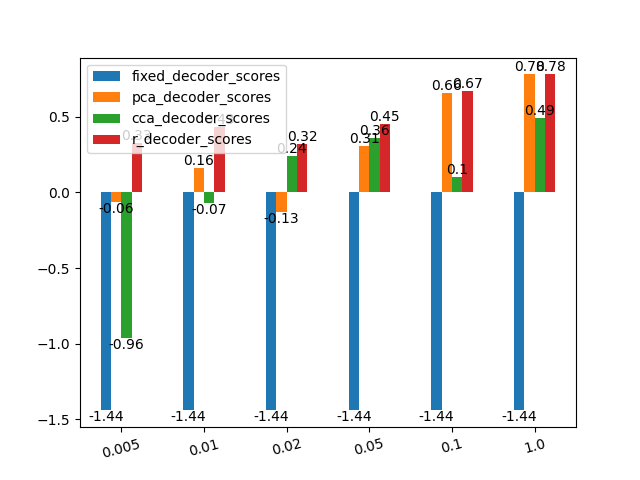

In [15]:
%matplotlib widget
%matplotlib widget

plot_dict = {}
plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
plot_dict['pca_decoder_scores'] = pca_decoder_scores
plot_dict['cca_decoder_scores'] = cca_decoder_scores
plot_dict['r_decoder_scores'] = r_scores

index = subsample_list

df = pd.DataFrame(data=plot_dict, index=index)

  
# plot grouped bar chart
ax = df.plot.bar(rot=15)
for container in ax.containers:
    ax.bar_label(container)